# imports

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# EDA

## Load data and quick cleaning

In [21]:
df_kag = pd.read_csv("../src/emotion_kaggle.csv")
df_aug = pd.read_csv("../src/emotion_data_augmentation.csv")

### df kaggle

In [32]:
df_kag

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
21454,Melissa stared at her friend in dism,fear
21455,Successive state elections have seen the gover...,fear
21456,Vincent was irritated but not dismay,fear
21457,Kendall-Hume turned back to face the dismayed ...,fear


In [23]:
# clean columns' name
df_kag.columns = list(map(lambda x: x.lower(), df_kag.columns))

In [24]:
df_kag.columns

Index(['text', 'emotion'], dtype='object')

In [25]:
df_kag["emotion"].value_counts()

happy       7029
sadness     6265
anger       2993
fear        2652
love        1641
surprise     879
Name: emotion, dtype: int64

Text(0.5, 1.0, 'Count by emotion')

<Figure size 1080x504 with 0 Axes>

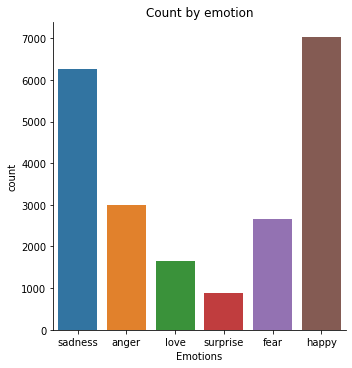

In [42]:
plt.figure(figsize=(15,7))

sns.catplot(x="emotion", kind="count", data=df_kag)

plt.xlabel('Emotions')
plt.title('Count by emotion')

### df augmentation

In [35]:
df_aug

,text,emotion
0,@tiffanylue i know i was listenin to bad habi...,empty
1,Layin n bed with a headache ughhhh...waitin o...,sadness
2,Funeral ceremony...gloomy friday...,sadness
3,wants to hang out with friends SOON!,enthusiasm
4,@dannycastillo We want to trade with someone w...,neutral
...,...,...
39995,@JohnLloydTaylor,neutral
39996,Happy Mothers Day All my love,love
39997,Happy Mother's Day to all the mommies out ther...,love
39998,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...,happiness


In [27]:
df_aug = df_aug[["content", "sentiment"]]

In [28]:
df_aug.columns = df_kag.columns
df_aug.columns

Index(['text', 'emotion'], dtype='object')

In [29]:
df_aug["emotion"].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: emotion, dtype: int64

Text(0.5, 1.0, 'Count by emotion')

<Figure size 1080x720 with 0 Axes>

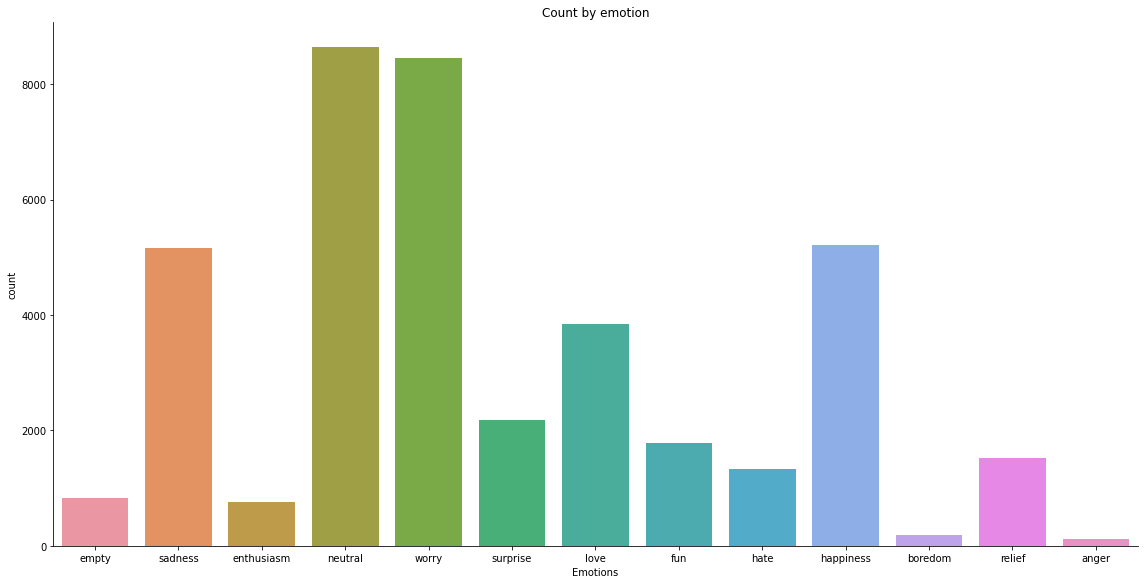

In [47]:
plt.figure(figsize=(15,10))

sns.catplot(x="emotion", kind="count", data=df_aug, height=8, aspect=2)

plt.xlabel('Emotions')
plt.title('Count by emotion')

#### clean emotion

In [49]:
[i for i in df_aug["emotion"].unique() if i not in df_kag["emotion"].unique()]

['empty',
 'enthusiasm',
 'neutral',
 'worry',
 'fun',
 'hate',
 'happiness',
 'boredom',
 'relief']

In [50]:
df_kag["emotion"].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'happy'],
      dtype=object)

In [59]:
emotion_map = {"empty":"sadness",
                "enthusiasm":"happy",
                "worry":"fear",
                "fun":"surprise",
                "hate":"anger",
                "happiness":"happy",
                "boredom":"sadness",
                "relief":"happy",
                'sadness':'sadness',
                'anger':'anger',
                'love':'love',
                'surprise':'surprise',
                'fear':'fear',
                'happy':'happy',
                "neutral":"neutral"}

In [55]:
df_aug.emotion

0             empty
1           sadness
2           sadness
3        enthusiasm
4           neutral
            ...    
39995       neutral
39996          love
39997          love
39998     happiness
39999          love
Name: emotion, Length: 40000, dtype: object

In [63]:
df_aug.emotion = df_aug.emotion.map(emotion_map)

C:\Users\Apprenant\AppData\Local\Temp\ipykernel_9436\886341324.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aug.emotion = df_aug.emotion.map(emotion_map)


Text(0.5, 1.0, 'Count by emotion')

<Figure size 1080x720 with 0 Axes>

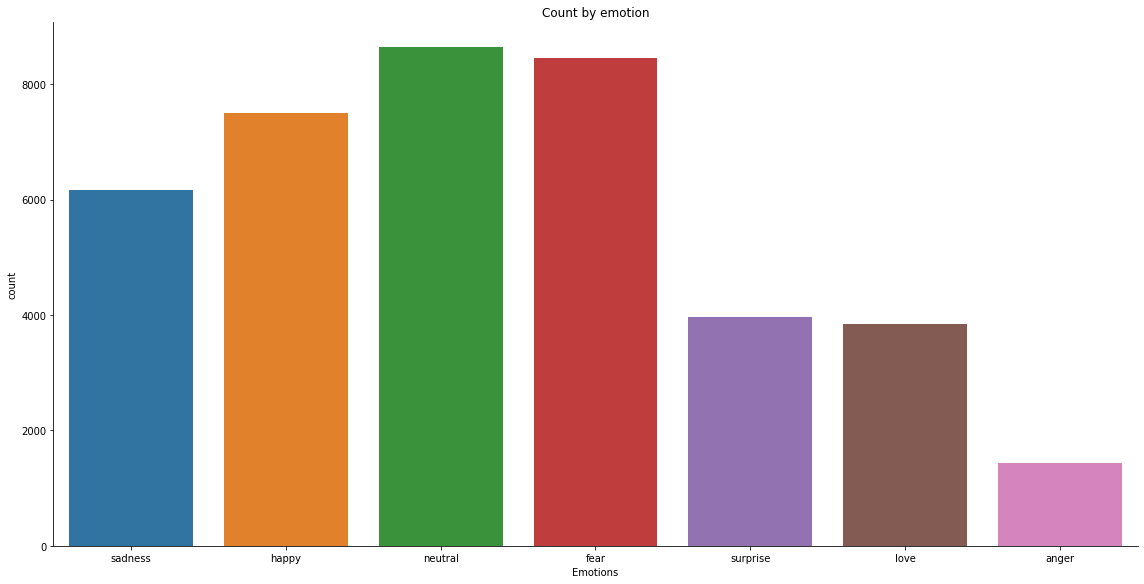

In [65]:
plt.figure(figsize=(15,10))

sns.catplot(x="emotion", kind="count", data=df_aug, height=8, aspect=2)

plt.xlabel('Emotions')
plt.title('Count by emotion')

# Preprocessing

In [128]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from collections import defaultdict, Counter
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import confusion_matrix
import itertools


from urllib.parse import urlparse
import mlflow
import mlflow.sklearn
# experiment_id = mlflow.create_experiment("nlp_emotion")

import warnings
warnings.filterwarnings('ignore')

In [67]:
df_kag.emotion.value_counts(normalize=True)

happy       0.327555
sadness     0.291952
anger       0.139475
fear        0.123585
love        0.076471
surprise    0.040962
Name: emotion, dtype: float64

In [89]:
my_stop_word = ["feel", "feeling", "like", "t", "'",",","im","know","s","mei","don","m","bit","think", "want", "people", "dont"]
for i in my_stop_word :
    STOP_WORDS.add(i)

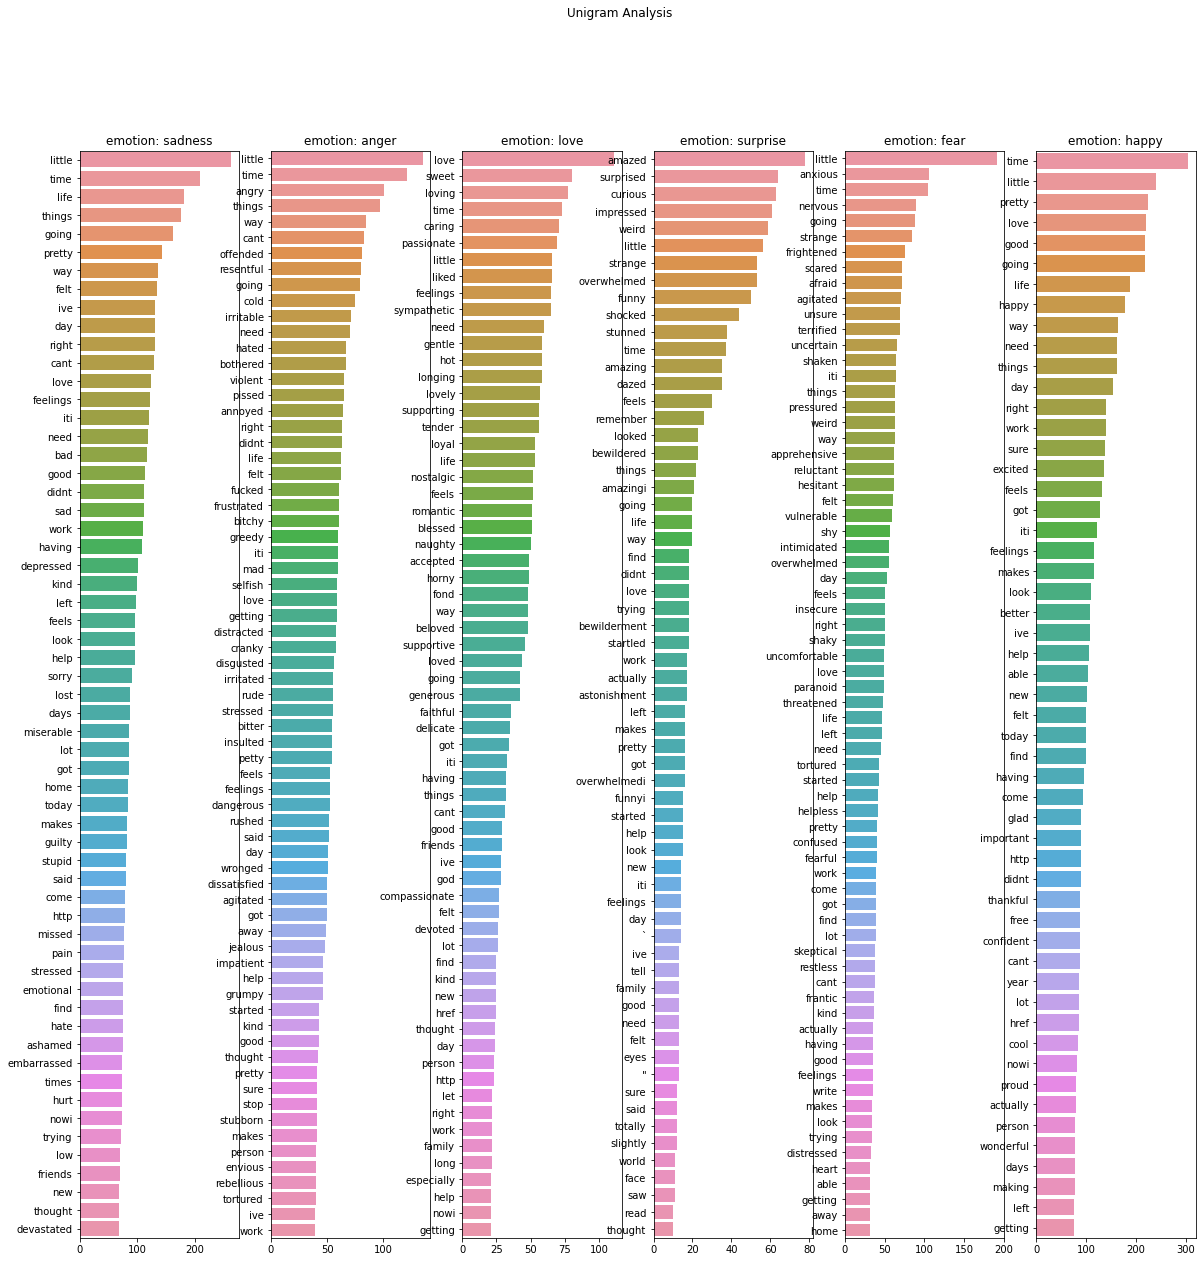

In [91]:
fig, axes = plt.subplots(1,len(df_kag.emotion.unique()), figsize=(20,20))
fig.suptitle('Unigram Analysis')

for index,emotion in enumerate(df_kag.emotion.unique()):
    dct=defaultdict(int) 
    curdf=df_kag[df_kag['emotion']==emotion]  
    allwordsarr=curdf.text.str.cat().split()
    counter=Counter(allwordsarr)
    most=counter.most_common()
    x=[]
    y=[]
    for word,count in most[:200]:
        if (word.lower() not in STOP_WORDS):
            x.append(word)
            y.append(count)
    sns.barplot(ax=axes[index],x=y,y=x)
    axes[index].set_title("emotion: "+str(emotion))

Bigram analysis


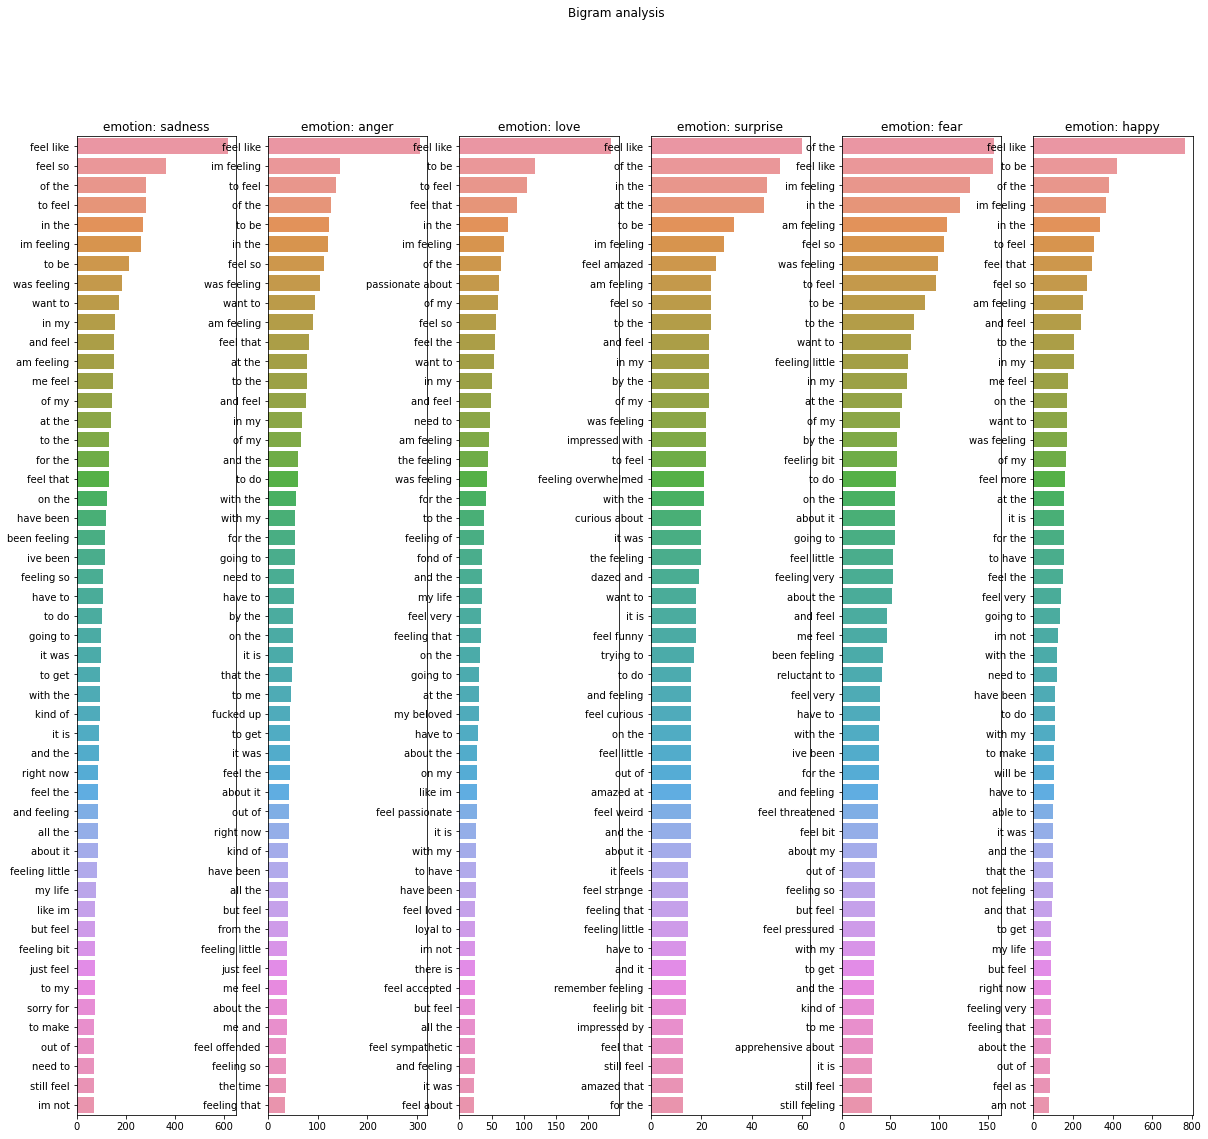

In [93]:
def get_top_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

print("Bigram analysis")

fig, axes = plt.subplots(1,len(df_kag.emotion.unique()), figsize=(20,18))
fig.suptitle('Bigram analysis')

for index,emotion in enumerate(df_kag.emotion.unique()):
    dct=defaultdict(int) 
    top_bigrams=get_top_bigrams(df_kag[df_kag['emotion']==emotion].text)[:50]
    x,y=map(list,zip(*top_bigrams))
    sns.barplot(ax=axes[index],x=y,y=x)
    axes[index].set_title("emotion: "+str(emotion))

fig.show()

In [96]:
count_vect = CountVectorizer(max_df=0.9, min_df=2)
train_counts = count_vect.fit_transform(df_kag["text"])
print(f"dimension de la matrice de comptage: {train_counts.shape}")

dimension de la matrice de comptage: (21459, 9195)


In [97]:
print(train_counts)

  (0, 2216)	1
  (0, 3034)	1
  (0, 3940)	1
  (1, 1135)	1
  (1, 3480)	1
  (1, 3305)	2
  (1, 3036)	1
  (1, 7420)	2
  (1, 3882)	1
  (1, 8254)	1
  (1, 1959)	1
  (1, 3880)	1
  (1, 4422)	1
  (1, 739)	1
  (1, 450)	1
  (1, 7464)	1
  (1, 8963)	1
  (1, 1175)	1
  (1, 314)	1
  (1, 4294)	1
  (1, 578)	1
  (2, 3034)	1
  (2, 8254)	1
  (2, 4009)	1
  (2, 3518)	1
  :	:
  (21454, 2300)	1
  (21455, 8125)	1
  (21455, 3717)	1
  (21455, 7048)	1
  (21455, 1099)	1
  (21455, 2302)	1
  (21455, 7641)	1
  (21455, 5741)	1
  (21455, 2597)	1
  (21456, 8848)	1
  (21456, 1088)	1
  (21456, 5411)	1
  (21456, 4292)	1
  (21456, 8749)	1
  (21456, 2301)	1
  (21457, 8254)	1
  (21457, 8125)	1
  (21457, 8459)	1
  (21457, 600)	1
  (21457, 2936)	1
  (21457, 2302)	1
  (21458, 275)	1
  (21458, 1088)	1
  (21458, 5411)	1
  (21458, 2302)	1


In [100]:
# on peut retrouver l'indexe de chaque mot
print(count_vect.vocabulary_.get(u'trump'))
print(count_vect.vocabulary_.get(u'india'))
print(count_vect.vocabulary_.get(u'good'))
print(count_vect.vocabulary_.get(u'bad'))
print(count_vect.vocabulary_.get(u'hell'))
print(count_vect.vocabulary_.get(u'fear'))

None
4101
3497
610
3772
3014


In [109]:
def cv(data,stop_words):
    count_vectorizer = CountVectorizer(stop_words=stop_words)
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer

In [110]:
list_corpus = df_kag['text']#.tolist()
list_labels = df_kag['emotion']#.tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40)

In [111]:
X_train_counts, count_vectorizer = cv(X_train, STOP_WORDS)
X_test_counts = count_vectorizer.transform(X_test)

In [112]:
list(count_vectorizer.vocabulary_.items())[:10]

[('relieved', 12148),
 ('better', 1419),
 ('kind', 8171),
 ('regretful', 12083),
 ('aching', 162),
 ('times', 15011),
 ('day', 3623),
 ('sociable', 13626),
 ('date', 3607),
 ('monday', 9511)]

In [115]:
df_kag["emotion"].unique().tolist()

['sadness', 'anger', 'love', 'surprise', 'fear', 'happy']

In [118]:
colors = ['blue','red',"green","cyan","magenta","yellow"]

In [121]:
[mpatches.Patch(color=i, label=j) for j,i in zip(df_kag["emotion"].unique().tolist(), colors)]

In [126]:
def plot_LSA(test_data, test_labels, savepath="PCA.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['blue','red',"green","cyan","magenta","yellow","black"]
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, cmap=matplotlib.colors.ListedColormap(colors), label=df_kag["emotion"].unique().tolist())
            plt.legend(handles=[mpatches.Patch(color=i, label=j) for j,i in zip(df_kag["emotion"].unique().tolist(), colors)], prop={'size': 25})

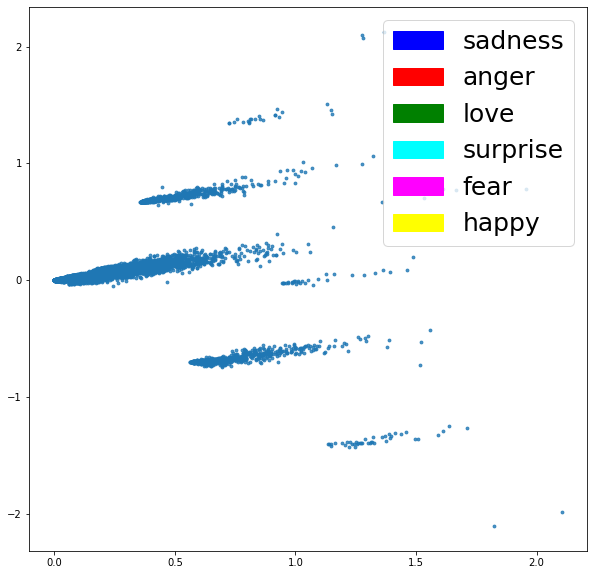

In [127]:
fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_train_counts, y_train)
plt.show()

# Model

In [131]:
from sklearn.metrics import accuracy_score, classification_report

## MultinomialNB

In [145]:
from sklearn.naive_bayes import MultinomialNB

In [149]:
with mlflow.start_run(experiment_id = 1):
    clf = MultinomialNB()
    clf.fit(X_train_counts, y_train)

    y_predicted_counts = clf.predict(X_test_counts)


    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(clf, "model", registered_model_name="multinominalnb")
    else:
        mlflow.sklearn.log_model(clf, "model") 

In [150]:
accuracy_score(y_test, y_predicted_counts)

0.7924044734389561

In [151]:
print(classification_report(y_test, y_predicted_counts))

              precision    recall  f1-score   support

       anger       0.91      0.69      0.78       598
        fear       0.82      0.68      0.74       529
       happy       0.77      0.94      0.85      1419
        love       0.86      0.38      0.53       337
     sadness       0.77      0.91      0.84      1226
    surprise       0.89      0.22      0.36       183

    accuracy                           0.79      4292
   macro avg       0.84      0.64      0.68      4292
weighted avg       0.81      0.79      0.78      4292



## nltk and MultinomialNB

In [176]:
import nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer

class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
vect_nltk = CountVectorizer(tokenizer=LemmaTokenizer()) 

In [177]:
# from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline

In [178]:
text_clf = Pipeline([
    ('vect', vect_nltk),
    ('clf', MultinomialNB()),
])

In [179]:
from sklearn.model_selection import GridSearchCV

vect_params = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'vect__strip_accents': [None, 'ascii'],
    'vect__stop_words': ["english", STOP_WORDS],
    'vect__max_df': [1, 0.9,0.8,0.7],
    'vect__min_df': [1, 2, 3, 4]
}

clf_params = {
    "clf__alpha": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "clf__fit_prior": [True, False],
    # "clf__class_prior" : []
}

params = [vect_params, clf_params]

In [180]:
gs_clf = GridSearchCV(text_clf,param_grid=params, scoring= "accuracy", cv=5, n_jobs=-1, verbose=3)

In [181]:
gs_clf = gs_clf.fit(X_train, y_train)

Fitting 5 folds for each of 212 candidates, totalling 1060 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 1060 out of 1060 | elapsed: 20.5min finished


In [183]:
print(gs_clf.best_score_)

0.8463329047388726


In [184]:
gs_clf.best_params_

{'vect__max_df': 0.9,
 'vect__min_df': 4,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': 'english',
 'vect__strip_accents': None}